In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os

from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [4]:
# a general practice

# 1. 数据准备
# 假设我们有一个原子特征向量数据集 X，形状为 (N, D)，N 是样本数，D 是特征维度
# 这里生成一个示例数据集
np.random.seed(42)
N = 1000  # 样本数
D = 8     # 特征维度
X = np.random.randn(N, D)  # 随机生成数据集



In [5]:
# 尝试不同的 M 值
M_values = range(1, 11)  # 尝试 M 从 1 到 10
bic_values_new = []

for M in M_values:
    gmm = GaussianMixture(n_components=M, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_values_new.append(gmm.bic(X))  # 计算 BIC 值

# 选择使 BIC 最小的 M
optimal_M = M_values[np.argmin(bic_values_new)]
print(f"最优的 M 值: {optimal_M}")

最优的 M 值: 1


In [6]:
# 2. 训练GMM模型
# 使用 scikit-learn 的 GaussianMixture 进行训练
M = 5  # 高斯分布的数量
gmm = GaussianMixture(n_components=M, covariance_type='full', max_iter=100, random_state=42)
gmm.fit(X)  # 拟合GMM模型


GaussianMixture(n_components=5, random_state=42)

In [7]:

# 3. 不确定性估计
# 对于测试数据点 x_test，计算其负对数似然（NLL）
x_test = np.random.randn(1, D)  # 随机生成一个测试数据点
log_prob = gmm.score_samples(x_test)  # 计算对数概率
nll = -log_prob  # 负对数似然

print(f"测试数据点的负对数似然 (NLL): {nll[0]:.4f}")

# 4. 可视化GMM的参数（可选）
print("GMM权重 (w_m):", gmm.weights_)
print("GMM均值 (mu_m):", gmm.means_)
print("GMM协方差矩阵 (Sigma_m):", gmm.covariances_)

测试数据点的负对数似然 (NLL): 9.9210
GMM权重 (w_m): [0.17534433 0.23059292 0.21211621 0.21908867 0.16285787]
GMM均值 (mu_m): [[-0.48396646 -0.16228132 -0.0625338  -0.18875451  0.00955902 -0.85135721
   0.14355433 -0.63756927]
 [-0.15731087  0.28331638 -0.03783023  0.04322699 -0.39767263 -0.16545481
  -0.36367122  0.63708427]
 [ 0.1125077  -0.4657117   0.29765625  0.43433067  0.29782723  0.42658057
  -0.53045767 -0.16189565]
 [ 0.29624936  0.37670129 -0.06797273 -0.45328888  0.71991969  0.30898932
   0.01150631 -0.06553627]
 [ 0.17688159 -0.31170241 -0.39791857  0.09851115 -0.45557958  0.09610197
   0.93883719  0.26307594]]
GMM协方差矩阵 (Sigma_m): [[[ 8.35897991e-01  4.32339610e-02 -2.71557543e-02 -1.21433411e-01
   -3.29498573e-02 -2.10198694e-01 -4.73325938e-02 -6.19463343e-04]
  [ 4.32339610e-02  9.60506932e-01 -5.23136727e-02  2.14314897e-02
   -2.35987620e-02 -9.98834610e-02  1.18953227e-01 -1.23671613e-01]
  [-2.71557543e-02 -5.23136727e-02  9.65849299e-01 -3.31678129e-02
   -1.30627630e-01  6.59933

In [8]:
# load data
desc_string = 'descriptors/*/desc.npy'
dpdata_name = "FeCHO-clean-v2-7-20873"
dpdata_path = "./data-clean-v2-7-20873-npy"
dpdata_string = "O*"

In [9]:
# define used function
def extract_elements_array(data: dpdata.LabeledSystem) -> list:
    '''extract elements array from dpdata for draw t-SNE'''
    types = data.data['atom_types']
    names = data.data['atom_names']
    ele_array = [names[ind] for ind in types]
    return ele_array

# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_keys = []
all_desc_stru = []
for f in glob.glob(desc_string):
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_keys.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    all_desc_stru.append(one_desc_stru)
all_desc_stru = np.concatenate(all_desc_stru, axis=0)
np.shape(all_desc_stru)

Reading descriptor results...


(20873, 136)

In [10]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata =  dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

MultiSystems (694 systems containing 20873 frames)

In [11]:
alldata_dict = {}
for lbsys in alldata:
    alldata_dict[lbsys.short_name] = lbsys

# get list of system name
sys_list = []
for keyname in desc_keys:
    target_sys = alldata_dict[keyname]
    for ind in range(target_sys.get_nframes()):
        sys_list.append(f"{keyname}-{ind}")
    
# get element ratio
element_ratio_dict = {}
element_names = alldata[0].get_atom_names()
for element in element_names:
    ratio_for_ele = []
    for keyname in desc_keys:
        target_sys = alldata_dict[keyname]
        ratio = target_sys.get_atom_numbs()[target_sys.get_atom_names().index(element)] / np.sum(target_sys.get_atom_numbs())
        ratio_for_ele.extend([ratio] * target_sys.get_nframes())
    element_ratio_dict[element] = ratio_for_ele

In [ ]:
# 尝试不同的 M 值
M_values = range(10, 40)  # 尝试 M 从 1 到 20
bic_values = [-13828760.6328262,
 -16124263.473793956,
 -16700779.97840544,
 -17153720.649649102,
 -17250566.966042615,
 -17473201.829664845,
 -17577903.616495498,
 -17820415.07022099,
 -18192125.99617989,
 -18191669.236036282,
 -18214515.951762322,
 -18391690.918408792,
 -18355628.354964457,
 -18368214.223107353,
 -18340171.805149946,
 -18375236.127908256,
 -18434040.733593017,
 -18400620.685319636,
 -18359427.62594295]
bic_values_new = bic_values[:10]
X = all_desc_stru

for M in M_values:
    gmm = GaussianMixture(n_components=M, 
                          covariance_type='full', 
                          random_state=42,
                          max_iter=100)
    gmm.fit(X)
    bic_values_new.append(gmm.bic(X))  # 计算 BIC 值

# 选择使 BIC 最小的 M
optimal_M = M_values[np.argmin(bic_values_new)]
print(f"最优的 M 值: {optimal_M}")

最优的 M 值: 27


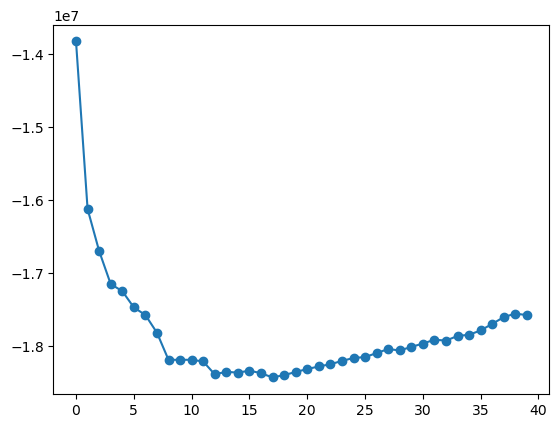

In [30]:
plt.plot(range(len(bic_values_new)), bic_values_new, marker='o')

In [38]:
# 2. 训练GMM模型
# 使用 scikit-learn 的 GaussianMixture 进行训练
M = 27  # 高斯分布的数量
X = all_desc_stru
gmm = GaussianMixture(n_components=M, covariance_type='full', max_iter=200, random_state=42)
gmm.fit(X)  # 拟合GMM模型


GaussianMixture(max_iter=200, n_components=27, random_state=42)

In [39]:
all_desc_stru.shape

(20873, 136)

In [37]:
# 4. 可视化GMM的参数（可选）
print("GMM权重 (w_m):", gmm.weights_)
print("GMM均值 (mu_m):", gmm.means_)
print("GMM协方差矩阵 (Sigma_m):", gmm.covariances_)

GMM权重 (w_m): [0.12460919 0.01734298 0.03372774 0.01997795 0.06778102 0.0147559
 0.01188138 0.05504723 0.0158099  0.0421117  0.01595362 0.0076175
 0.01842032 0.07392099 0.02117568 0.13695656 0.02584741 0.1759494
 0.00416806 0.01173765 0.00924639 0.02649367 0.01796587 0.01466009
 0.00670723 0.0264456  0.00368898]
GMM均值 (mu_m): [[ 0.13929802  0.1010704  -0.02288674 ... -0.17615222 -0.26702299
  -0.03361492]
 [-0.25984805  0.01980332 -0.07369686 ... -0.17593576  0.27683625
   0.53842248]
 [ 0.47562202 -0.13669758 -0.02742668 ... -0.22872238 -0.23269537
  -0.13255303]
 ...
 [-0.08521821 -0.01522926 -0.21062342 ... -0.15596934  0.18067056
   0.52865221]
 [ 0.49604614 -0.00731594 -0.00759693 ... -0.23553603  0.14503412
   0.28085068]
 [-0.27744071  0.09385913 -0.08958705 ... -0.05246842 -0.35276288
   0.21537138]]
GMM协方差矩阵 (Sigma_m): [[[ 1.55961169e-03  1.04501517e-03  6.77709276e-05 ...  2.99431713e-05
   -3.05220511e-04 -1.01332083e-04]
  [ 1.04501517e-03  2.92685322e-03 -1.02224288e-04 ...

In [41]:
# 计算负对数似然不确定度
log_prob = gmm.score_samples(all_desc_stru)  # 计算对数概率
nll = -log_prob  # 负对数似然
nll

array([-433.82111261, -459.20412248, -458.9422989 , ..., -426.11021177,
       -455.87967735, -448.94083584])

In [42]:
# 给出前100个具有最大不确定度的样本编号
top_n = 100
top_n_ind = np.argsort(nll)[-top_n:]
top_n_ind

array([14326, 16559, 10121,  4794, 10794,  3581,  4409,  5856,  9880,
       10444,  4873, 18890, 17209,  5179, 13626, 18799, 17219, 13949,
        1288,  2593, 15445, 18825,  5609, 14743, 12976,  3427, 11218,
        5457,  1020,  6179, 18614,  8600, 19917, 20011, 15886, 16474,
        5079, 16090, 18854, 14075,  5627, 17171,  9878, 19916, 13362,
        4456, 15336, 18888,  2304,  4546, 15594, 18907,  4221, 11296,
        9877, 18900, 10828,  7525,  7520,  9896, 18809,  5043,  3505,
       15326,  4474,  9903, 15301, 19294, 16444,  5189, 18926, 18839,
       11467, 18512, 20448, 15767,  5409, 15323, 15706, 15367,  9879,
       15316,  4193, 12954,  9917, 15334, 15332,  3449,  6060,  4210,
        3368, 19494, 10805, 15328, 18848,  3475,  3446, 16561,  3421,
        7382])

In [45]:
target_vector = all_desc_stru.copy()
top_100_points = target_vector[top_n_ind]  # 获取对应的点

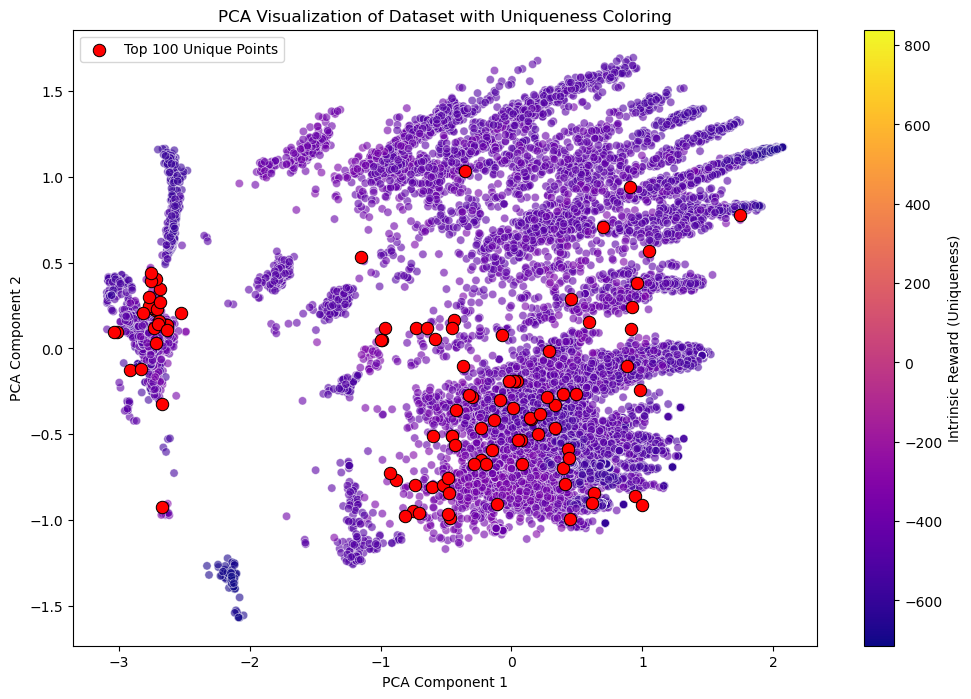

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

intrinsic_rewards = nll  # 使用负对数似然作为独特性度量


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_100_pca_result = pca.transform(top_100_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_100_pca_result[:, 0], y=top_100_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

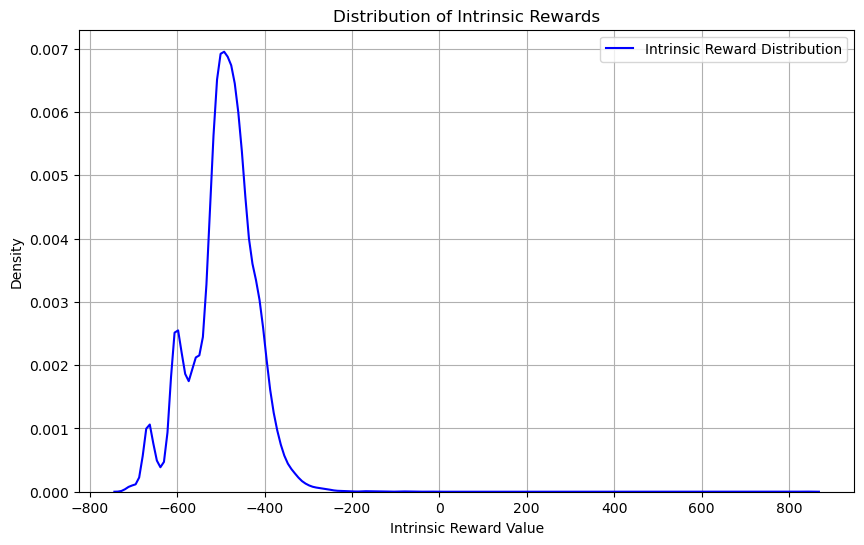

In [47]:
# 假设 intrinsic_rewards 是一个包含所有点内在奖励值的 numpy 数组
# intrinsic_rewards = np.random.rand(20873)  # 这里用随机数据代替，实际使用时替换为你的数据

# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

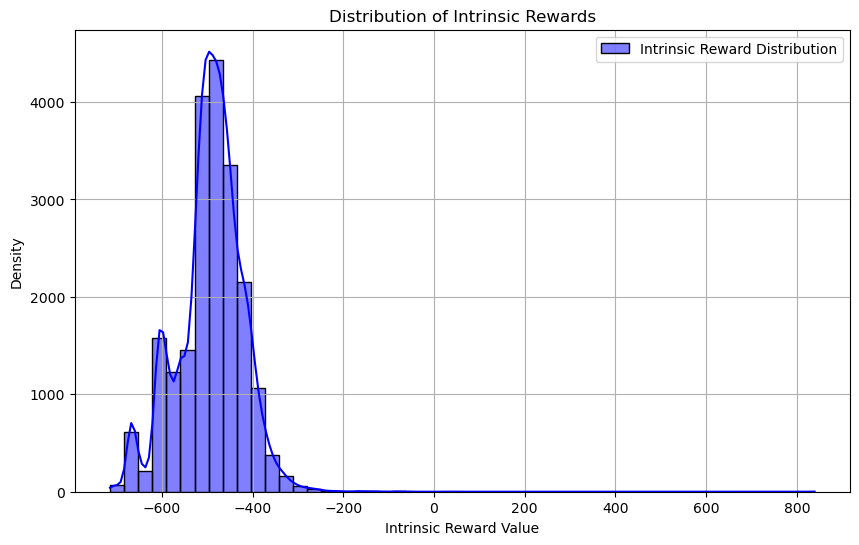

In [48]:
# 假设 intrinsic_rewards 是一个包含所有点内在奖励值的 numpy 数组
# intrinsic_rewards = np.random.rand(20873)  # 这里用随机数据代替，实际使用时替换为你的数据

# 直接按照出现频率绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()